# Import Libraries and functions

In [7]:
include("./../functions.jl")
include("./../plotting_functions.jl")
using LaTeXStrings
using JLD
using DataStructures
include("./sq_functions.jl")
import Random
using Statistics


# Construct the lattice and two ordered dimer coverings

In [8]:
N = 20
if N % 2 == 1
    println("Need N to be even so that vertical and horizontal states are defined")
end
sq_lat = get_sq_lat(N, pbc=false)
sq_lat_spin, latA, latB, sub_lat, G_to_spin, spin_to_G = get_sq_lat_spin(sq_lat)
covering = get_perfect_covering(latA, latB,sub_lat, sq_lat.nbr )
config = convering_to_config(covering, sq_lat_spin, G_to_spin);
config_vert = get_vert_col_state(sq_lat_spin, N)
config_hori = get_hori_col_state(sq_lat_spin, N)
;

In [9]:
function randomize_config(config::Vector{Bool}, sq_lat::Graph, sq_lat_spin::Graph, nsample::Int64)
    Random.seed!(1234)
    nsq = size(sq_lat.sq_plaq)[2]
    nspin = length(config)
    plaq_sq_spin = sq_lat_spin.sq_plaq

    for i in 1:nsample
        plaq_sq_move(config,plaq_sq_spin, nsq )
    end
    return config
end

randomize_config (generic function with 2 methods)

# Generate a random configuration

In [11]:
rand_config = randomize_config(config, sq_lat, sq_lat_spin, 1000)
;

## Plot a random dimer configuration

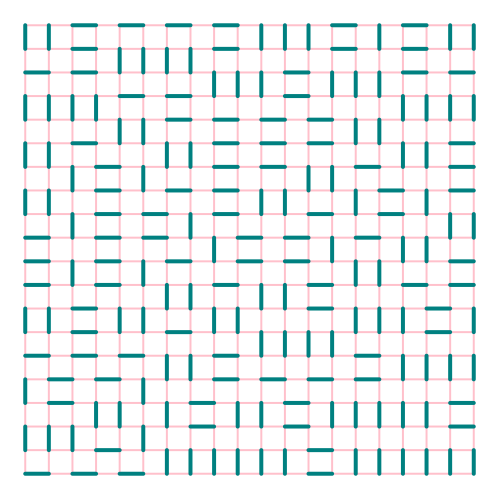

In [17]:
p = plot_generate(500)
plot_edges(p,sq_lat)
# plot_sites(p, sq_lat, annotate=false)
plot_config(p, rand_config,spin_to_G, sq_lat)
plot!(grid = false, axis=([], false))
display(p)


# Monte Carlo

### Define sampling functions

In [18]:
function sample_sz(running_sum::Vector{Int64}, config::Vector{Bool}, nspin::Int64)
    @simd for i in eachindex(running_sum)
        if @inbounds  config[i]
            @inbounds running_sum[i] = running_sum[i] + 1
        end
    end
end

function sample_sz_line(running_sum::Vector{Int64}, config::Vector{Bool}, line::Vector{Int64}, nline::Int64)
    for i in 1:nline
        if @inbounds config[line[i]]
            @inbounds running_sum[i] = running_sum[i] + 1
        end
    end
end

function sample_szsz_line(running_sum::Vector{Int64}, config::Vector{Bool}, line::Vector{Int64}, nline::Int64, origin::Int64)
    if @inbounds config[origin] == 1
        for i in 1:nline
            if @inbounds config[line[i]]
                @inbounds running_sum[i] = running_sum[i] + 1
            end
        end
    end
end

function sample_szsz(running_sum::Matrix{Int64}, config::Vector{Bool}, nspin::Int64)
    for i in 1:nspin-1
        if @inbounds config[i]
            for j in i+1:nspin
                if @inbounds config[i]
                    @inbounds running_sum[j,i] = running_sum[j,i] + 1
                end
            end
        end
    end
end

sample_szsz (generic function with 1 method)

In [19]:
function mc(config::Vector{Bool}, sq_lat::Graph, sq_lat_spin::Graph, N::Int64, nsample::Int64, nwait::Int64,fname::String )
    Random.seed!(1234)
    nsq = size(sq_lat.sq_plaq)[2]
    nspin = length(config)
    plaq_sq_spin = sq_lat_spin.sq_plaq
    
    origin_pt = N ÷ 2 + 0.5 + 1im* ( N ÷ 2 + 0.5) 
    origin = index_pts(sq_lat_spin.pts, origin_pt)
    line = findall(x -> (abs(imag(x - origin_pt)) < 1e-5) && ( real(x) > real(origin_pt) - 5.0), sq_lat_spin.pts)


    # nline = length(line)    
    # sz_line = deepcopy(line)
    # sz_line = pushfirst!(sz_line,origin)
    # nsz_line = length(sz_line)
    # sz = fill(0,length(sz_line))
    # szsz = fill(0,length(line))
    # sz_all = fill(0,nspin)
    # szsz_all = fill(0, nspin, nspin)
    f = open(fname,"w") 
    @showprogress for i in 1:nsample
        for j in 1:nwait
            while plaq_sq_move(config,plaq_sq_spin, nsq )
            end
        end
        write(f, config[line])

        # Sample correlators

        # sample_sz_line(sz, config, sz_line, nsz_line)
        # sample_szsz_line(szsz, config, line, nline, origin)
        # sample_sz(sz_all, config, nspin)
        # sample_szsz(szsz_all, config, nspin)


    end
    close(f)
    # sz = sz ./ nsample
    # szsz = szsz ./ nsample
    # sz_all = sz_all ./ nsample
    # szsz_all = szsz_all ./ nsample

    # return config, sz_all
    return config, line # sz_line, sz, line, szsz, sz_all, szsz_all
end

mc (generic function with 1 method)

In [ ]:
nwait = 1000
nsample = 2000#_000_0 # 5000_000_00
config = convering_to_config(covering, sq_lat_spin, G_to_spin);
config_vert = get_vert_col_state(sq_lat_spin, N)
config_hori = get_hori_col_state(sq_lat_spin, N)

# @time new_config, sz_vert = mc(config_vert, sq_lat, sq_lat_spin, nsample, nwait)
# @time new_config, sz_hori = mc(config_hori, sq_lat, sq_lat_spin, nsample, nwait)
# @time new_config, sz = mc(config, sq_lat, sq_lat_spin, nsample, nwait)
@time new_config,line = mc(config_vert, sq_lat, sq_lat_spin, N, nsample, nwait, "./../data/square_pbc_temp")
szsz_conn = szsz .- sz[2:end]*sz[1];

  0.160942 seconds (4.52 k allocations: 176.867 KiB, 10.84% compilation time)


UndefVarError: UndefVarError: `szsz` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

# Post process

In [117]:
function load_data(fnames::Vector{String}, sizes::Vector{Int64})
    data = [fill(false, 0,0) for _ in 1: length(fnames)]
    nt = 4
    @showprogress for i in 1:length(fnames)
        f = open(fnames[i]) do f
            readlines(f)
        end
        d = conv_to_arr(f[1], sizes[i] );
        data[i] = d
    end
    return data
end
dir = "./data/"

"./data/"

In [118]:
fnames = ["square_pbc_temp"] 
f = open(dir .* fnames[1]) do f
    readlines(f)
end
arr = conv_to_arr(f[1], length(line) );

In [140]:

origin_index = 1
vis = fill(0.0, length(line));
@showprogress for i in 1:length(line)
    vis[i] = vis_from_arr_ij(arr, origin_index, i)
end

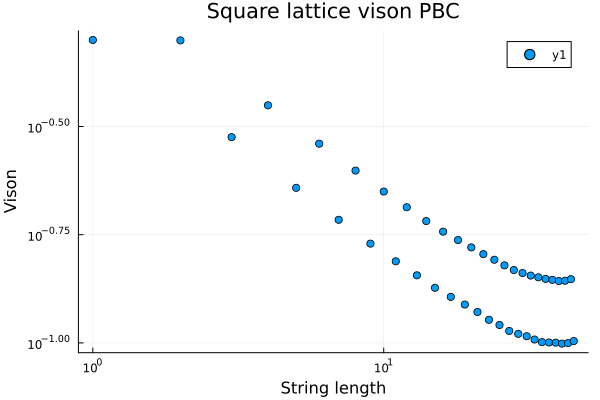

In [141]:
scatter(vis, yaxis=:log, xaxis=:log, xlabel="String length", ylabel="Vison", title="Square lattice vison PBC")

In [146]:
vis2 = vis[1:20]

20-element Vector{Float64}:
 0.5011878
 0.5000271
 0.2988245
 0.3539966
 0.2282475
 0.2886541
 0.1925233
 0.2501716
 0.1695897
 0.2237428
 0.1543798
 0.2058139
 0.1432787
 0.1912336
 0.1340856
 0.1807558
 0.1277541
 0.1728671
 0.1226591
 0.1662402

In [150]:
@show vis2

20-element Vector{Float64}:
 0.5011878
 0.5000271
 0.2988245
 0.3539966
 0.2282475
 0.2886541
 0.1925233
 0.2501716
 0.1695897
 0.2237428
 0.1543798
 0.2058139
 0.1432787
 0.1912336
 0.1340856
 0.1807558
 0.1277541
 0.1728671
 0.1226591
 0.1662402

In [ ]:
0.5005843
 0.5000229
 0.2992161
 0.354313
 0.2275919
 0.288051
 0.1919722
 0.2492691
 0.1691075
 0.2235158
 0.154142
 0.2059534
 0.1431153
 0.1921785
 0.1339201
 0.1813632

In [131]:
[0.5081602 , 0.51666588, 0.31251176, 0.37918772, 0.24495044,
       0.31912126, 0.21172998, 0.28561821, 0.19162653, 0.26425728,
       0.17791074, 0.24958698, 0.16783005, 0.23908253, 0.16003422]

15-element Vector{Float64}:
 0.5081602
 0.51666588
 0.31251176
 0.37918772
 0.24495044
 0.31912126
 0.21172998
 0.28561821
 0.19162653
 0.26425728
 0.17791074
 0.24958698
 0.16783005
 0.23908253
 0.16003422

In [54]:
origin = sz_line[1]
origin_pt = sq_lat_spin.pts[origin]
vecs = sq_lat_spin.pts[szsz_line] .- origin_pt
dist = [torus_distance(v, N) for v in vecs]
perm = sortperm(dist)

;

(c, m) = (-4.012282566302665, -0.6866225773803352)


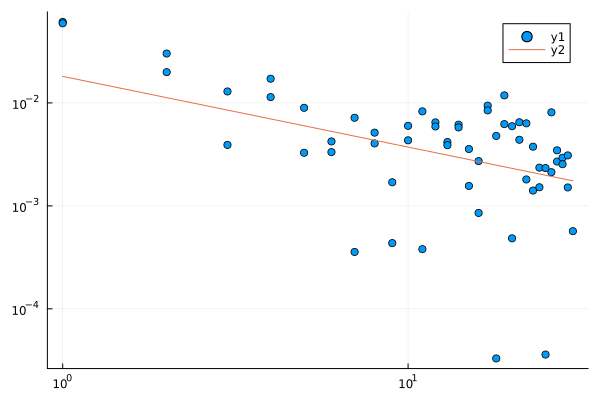

In [21]:
sort_dist = dist[perm]
sort_szsz = szsz_conn[perm]
p = scatter(sort_dist, abs.(sort_szsz), yaxis=:log, xaxis=:log)
rng = 3:55
c, m = linear_fit(log.(sort_dist)[rng], log.(abs.(sort_szsz))[rng])
@show c, m
x = 1:maximum(sort_dist)
# display(p)
plot!(x, exp.( m .* log.(x) .+ c) )

In [56]:
b = open("./data/square_pbc") do f
    readlines(f)
end
# @time arr = conv_to_arr(b[1], 25 )
@time arr = conv_to_arr(b[1], length(sz_line)-1 )

 10.991523 seconds (56 allocations: 5.919 GiB, 3.19% gc time)


59×30000000 Matrix{Bool}:
 0  0  0  1  0  0  0  1  0  0  0  0  0  …  0  0  1  0  0  0  0  1  0  0  0  0
 0  0  0  1  0  0  0  0  0  0  0  0  0     0  0  0  0  0  1  0  0  0  0  0  0
 0  0  0  0  0  1  0  1  0  0  0  0  1     0  1  1  0  1  0  1  1  1  0  1  1
 0  0  1  1  0  0  0  0  0  1  1  1  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  1  0  0  0  0  0  0     1  0  0  0  0  0  0  0  0  0  0  1
 0  0  0  1  0  0  0  0  0  0  0  0  1  …  0  0  1  0  0  0  1  1  1  1  0  0
 1  0  0  0  0  0  0  0  0  0  0  0  0     1  0  0  0  1  0  0  0  0  0  0  0
 0  0  0  0  1  0  0  1  1  0  0  0  0     0  0  1  1  0  0  0  0  1  1  1  1
 0  0  0  0  0  0  1  0  0  1  1  0  0     1  0  0  0  0  0  0  0  0  0  0  0
 0  0  1  0  1  1  0  1  1  0  0  0  0     0  0  0  0  1  0  0  0  0  1  1  0
 ⋮              ⋮              ⋮        ⋱        ⋮              ⋮           
 1  1  1  0  0  1  0  0  0  0  0  0  0  …  0  1  0  0  1  1  0  1  0  0  0  1
 0  0  0  0  0  0  1  0  1  1  0  1  0 

In [58]:
szsz = [szsz_frm_arr(arr, 1, i) for i in 2:size(arr)[1]]
sz1 = sz_frm_arr(arr, 1)
szsz_conn = [szsz[i] - sz1 * sz_frm_arr(arr, i+1) for i in 1:size(arr)[1]-1]
origin = sz_line[1]
origin_pt = sq_lat_spin.pts[origin]
vecs = sq_lat_spin.pts[szsz_line] .- origin_pt
dist = [torus_distance(v, N) for v in vecs]
perm = sortperm(dist)
;

In [66]:
sz_line

60-element Vector{Int64}:
   93
   94
  243
  363
  483
  603
  723
  843
  963
 1083
    ⋮
 6123
 6243
 6363
 6483
 6603
 6723
 6843
 6963
 7083

In [ ]:
sort_dist = dist[perm]
sort_szsz = szsz_conn[perm]
p = scatter(sort_dist, abs.(sort_szsz), yaxis=:log, xaxis=:log)
# rng = 3:55
# c, m = linear_fit(log.(sort_dist)[rng], log.(abs.(sort_szsz))[rng])
# @show c, m
# x = 1:maximum(sort_dist)
display(p)
# plot!(x, exp.( m .* log.(x) .+ c) )

BoundsError: BoundsError: attempt to access 58-element Vector{Float64} at index [[1, 2, 3, 59, 4, 58, 5, 57, 6, 56, 7, 55, 8, 54, 9, 53, 10, 52, 11, 51, 12, 50, 13, 49, 14, 48, 15, 47, 16, 46, 17, 45, 18, 44, 19, 43, 20, 42, 21, 41, 22, 40, 23, 39, 24, 38, 25, 37, 26, 36, 27, 35, 28, 34, 29, 33, 30, 32, 31]]

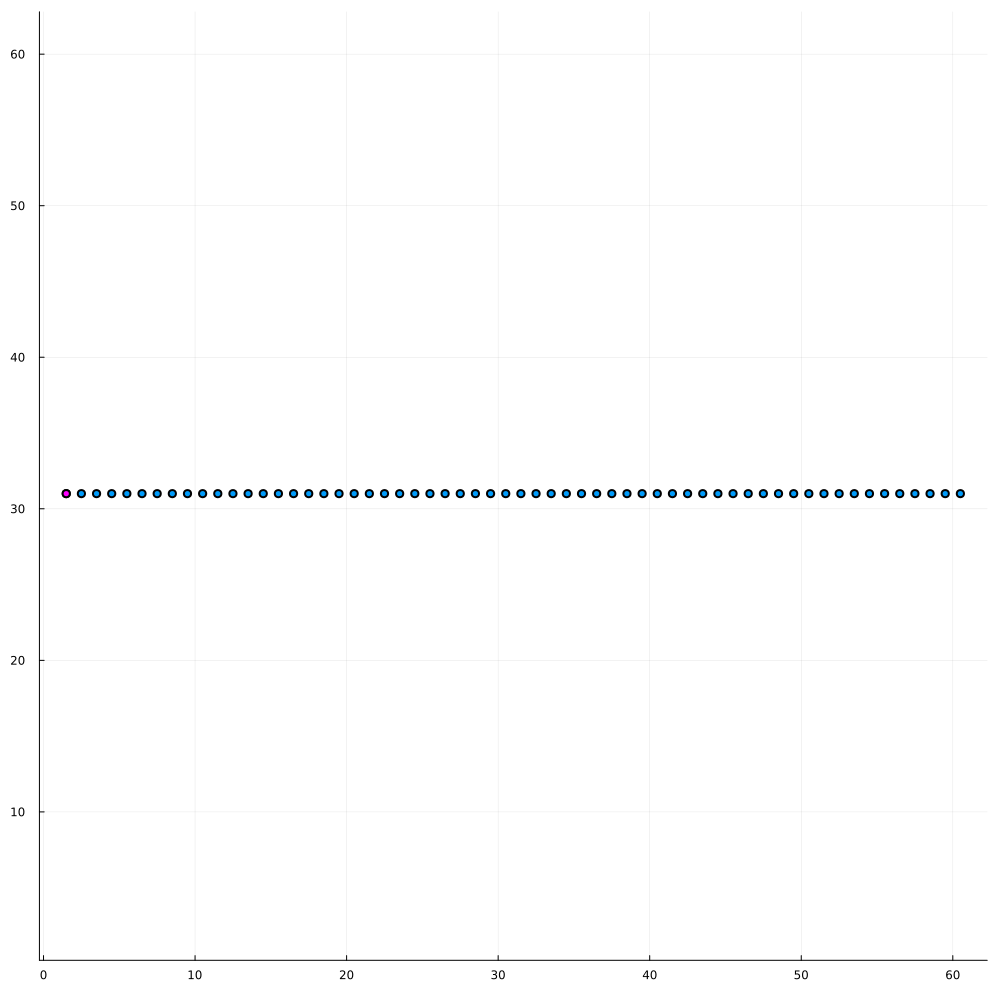

In [41]:
p = plot_generate(1000)
# plot_sites(p, sq_lat)
scatter!(real.(pp), imag.(pp))
scatter!([real.(pp[1])], [imag.(pp[1])], mc=:magenta)

display(p)

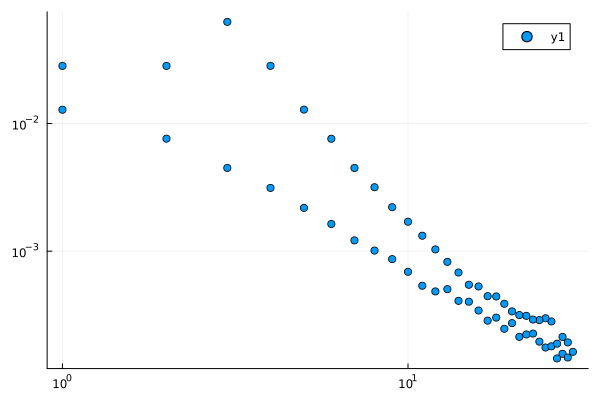

In [29]:
scatter(dist, abs.(szsz_conn), yaxis=:log, xaxis=:log)

In [75]:
vis = vis_frm_arr(arr)
# sort(vis)
;

In [81]:
26*2+10+15

77

In [82]:
80^8/1e12

1677.7216

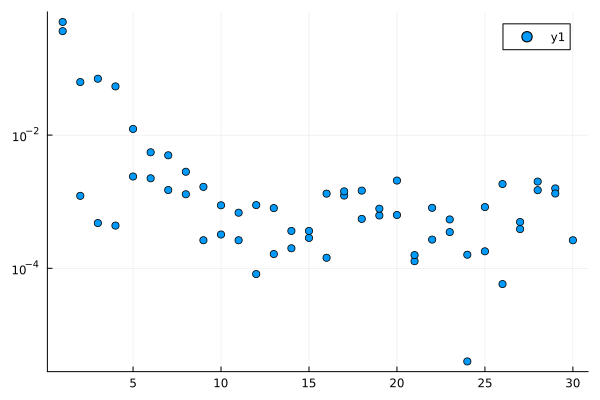

In [76]:
scatter(dist, vis, yaxis= :log)

In [12]:
origin_pt = sum(sq_lat.pts) / sq_lat.n - 0.5 - 28.0 -0.5 + 0.5im
origin = index_pts(sq_lat_spin.pts, origin_pt)
line = findall(x -> (abs(imag(x - origin_pt)) < 1e-5) && ( real(x) > real(origin_pt)), sq_lat_spin.pts)
;

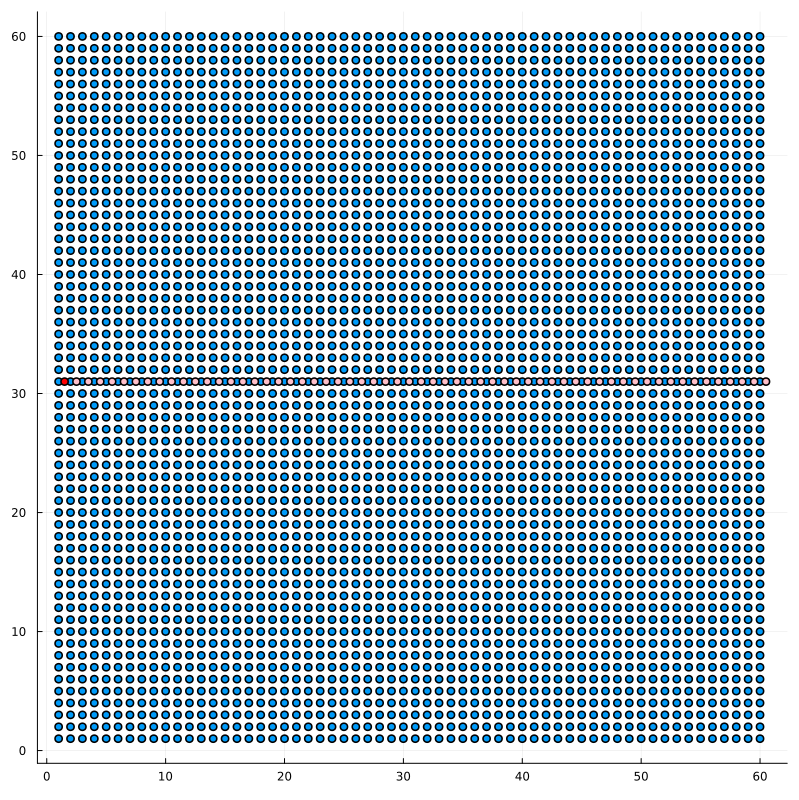

In [13]:
pp = sq_lat.pts
pp_spin = sq_lat_spin.pts
p = plot_generate(800)
scatter!(real.(pp), imag.(pp))
pt = pp_spin[origin]
pt_line = pp_spin[line]
scatter!([real.(pt)], [imag.(pt)], mc=:red)
scatter!(real.(pt_line), imag.(pt_line), mc=:pink)



In [ ]:
torus_distance(3.0 + 3.0im, 4)

In [ ]:
scatter(1:length(szsz_conn), abs.(szsz_conn), yaxis=:log, xaxis=:log)

In [ ]:
vis = vis_frm_arr(arr)
;

In [ ]:
scatter(1:length(vis), vis)

In [ ]:
origin_pt = sum(sq_lat.pts) / sq_lat.n - 0.5
origin = index_pts(sq_lat_spin.pts, origin_pt)

In [ ]:
line = findall(x -> (abs(imag(x - origin_pt)) < 1e-5) && ( real(x) > real(origin_pt)), sq_lat_spin.pts)